In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [131]:
from src.data_loader import ViTDataLoader
from src.vit_train import load_model_dir, ViTTrainer
from src.vit_data import load_cd_data_24x128_p1

model_dir = 'output/cd_24x128_2chan_p1_logfold_20220815_40a7'

vit, config = load_model_dir(model_dir, legacy=False)
vit_data = load_cd_data_24x128_p1(config.REPLICATE_MODE, config.CHANNEL_1, config.PREDICT_TPM)
config_name = "lfc"

dataloader = ViTDataLoader(vit_data, split_type=config.SPLIT_TYPE, split_arg=config.SPLIT_ARG, 
                           valid_type=config.VALIDATION_TYPE, valid_arg=config.VALIDATION_ARG)
print(dataloader.split_repr())

trainer = ViTTrainer(vit, config_name, dataloader, resume=True, resume_path=model_dir)


In [8]:
trainer.setup()

Resuming from 3500...


In [9]:
trainer.compute_predictions_losses()

Computing test predictions...Done. 1.212, 0.366
00:01:03.17
Computing train predictions...Done. 0.062, 0.939
00:05:42.81
Computing validation predictions...Done. nan, nan
00:05:42.81


In [10]:
print(trainer.perf_str)

Loss:
  Train:	0.062
  Valid:	nan
  Test: 	1.212

R2:
  Train:	0.939
  Valid:	nan
  Test: 	0.366


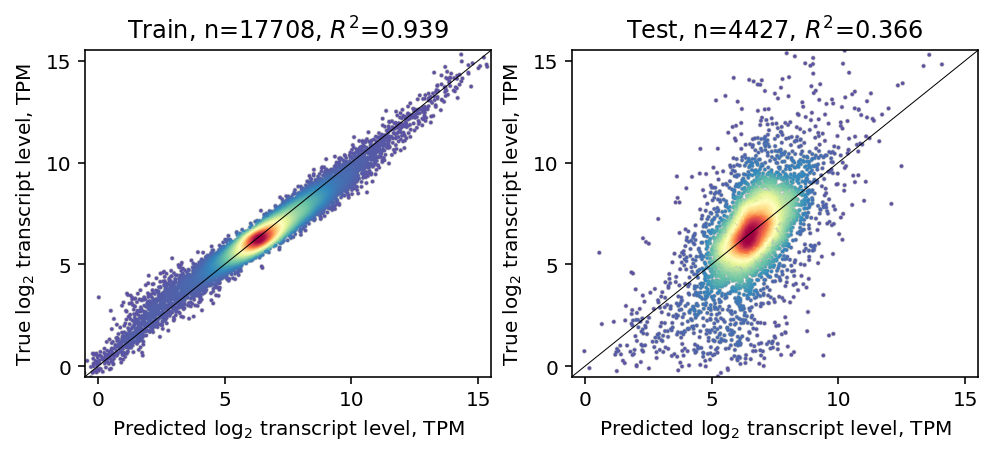

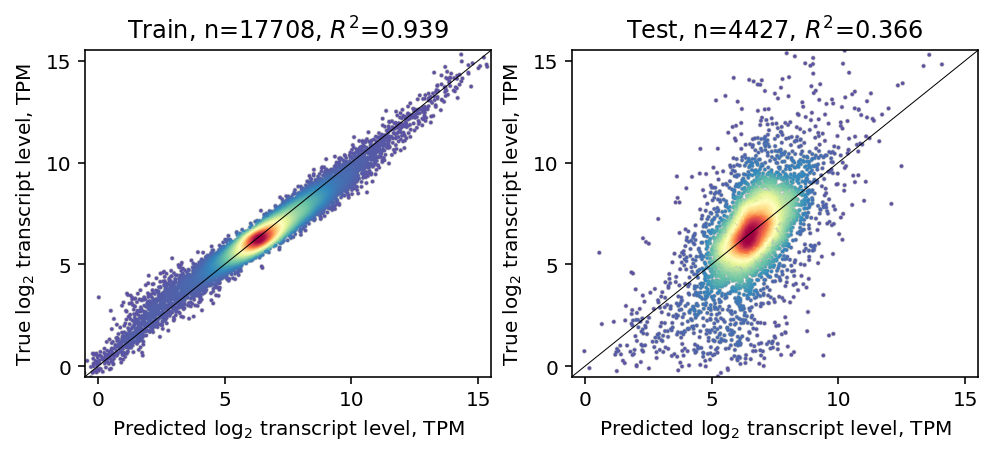

In [11]:
trainer.plot_predictions()

In [12]:
from src.rna_plotter import load_rna_plotter
from src.orf_plotter import ORFAnnotationPlotter

orf_plotter = ORFAnnotationPlotter()
rna_plotter = load_rna_plotter()
trainer.orf_plotter = orf_plotter
trainer.rna_plotter = rna_plotter


0

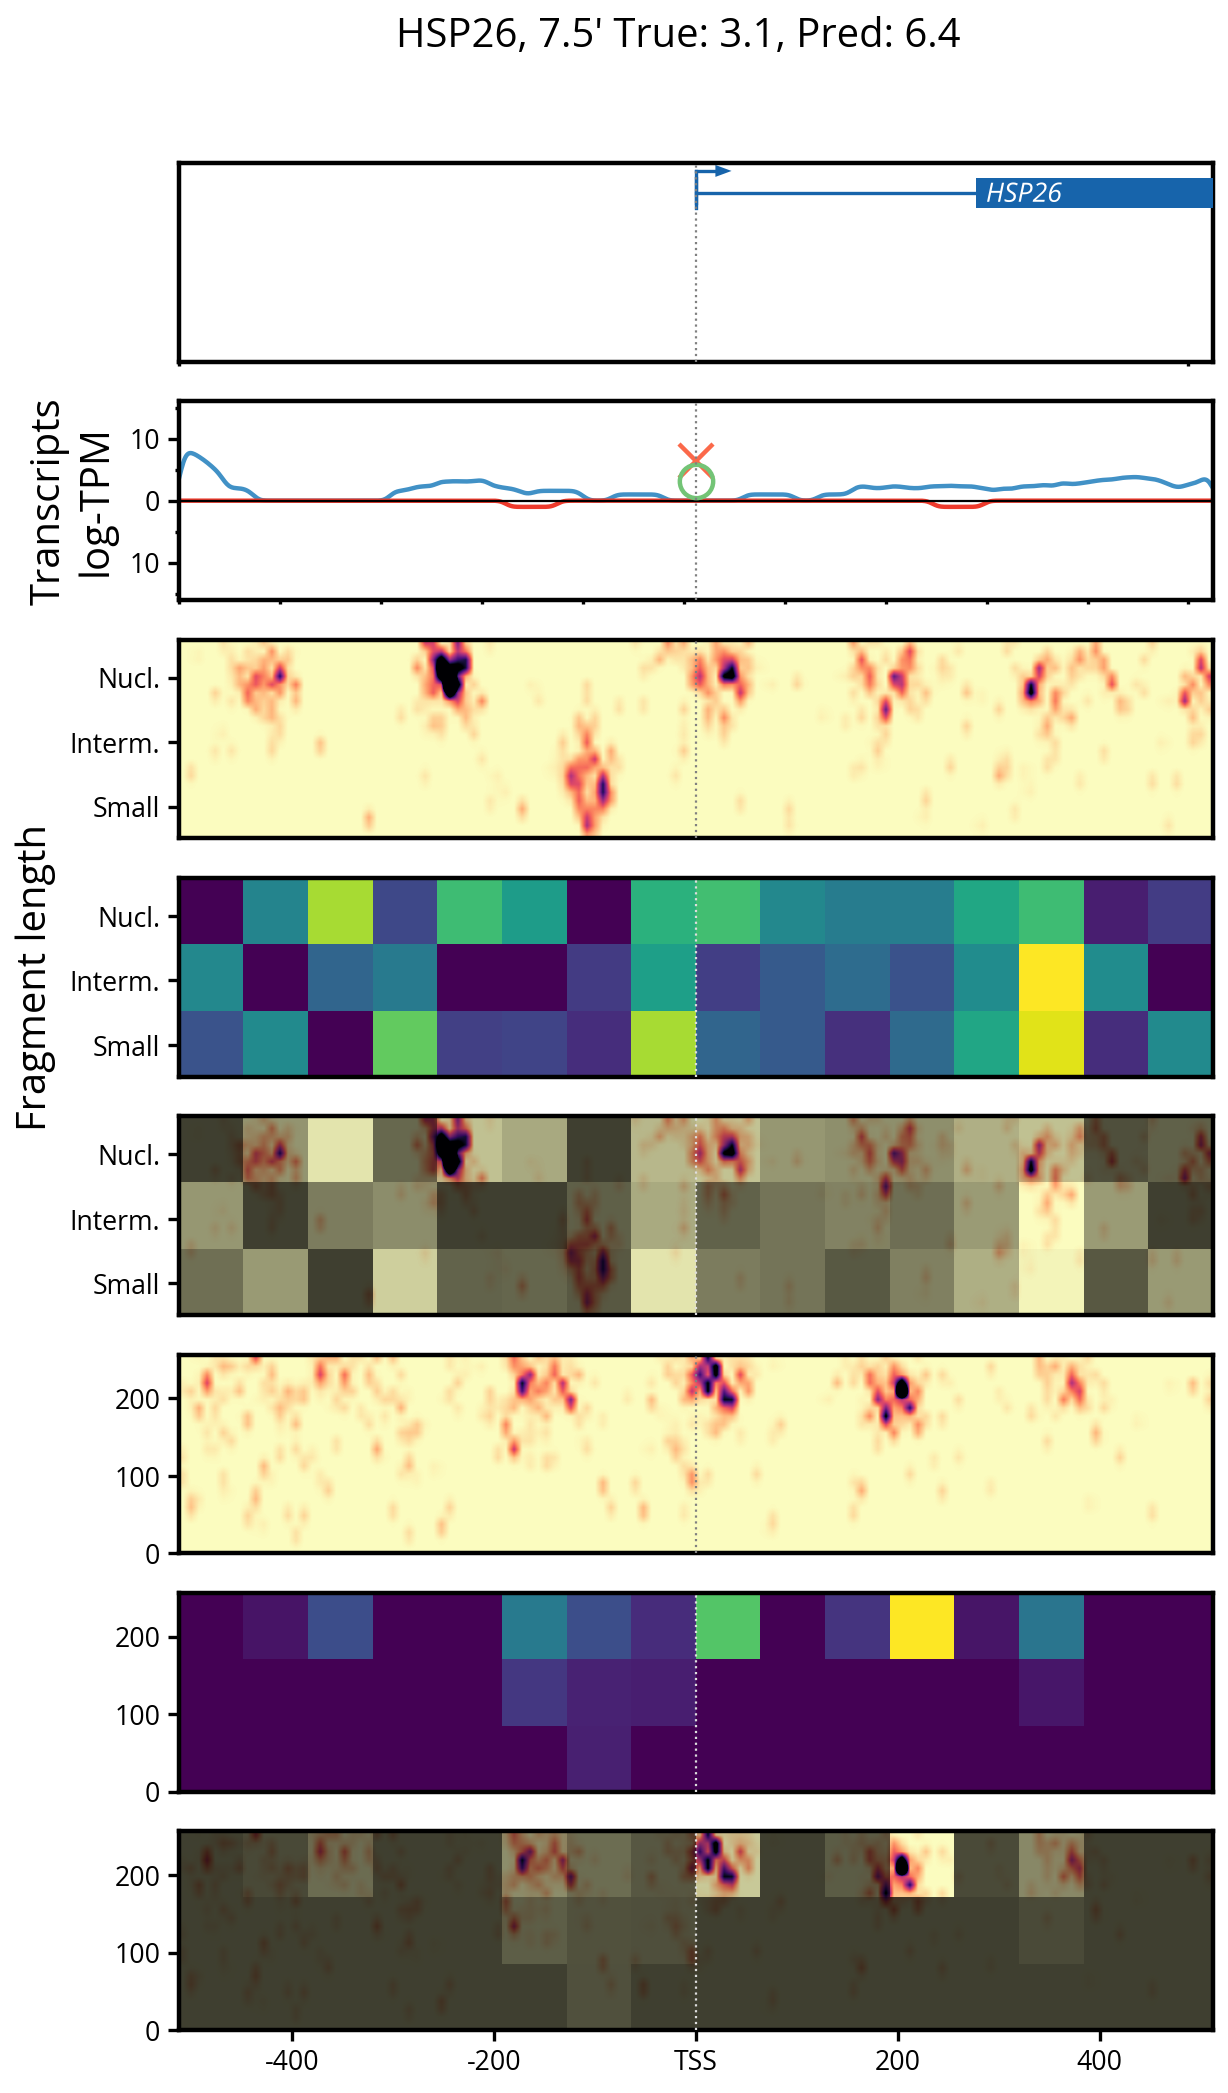

In [180]:
from src.vit_viz import plot_gene_prediction

trainer.plot_gene('HSP26', 7.5)
0

0

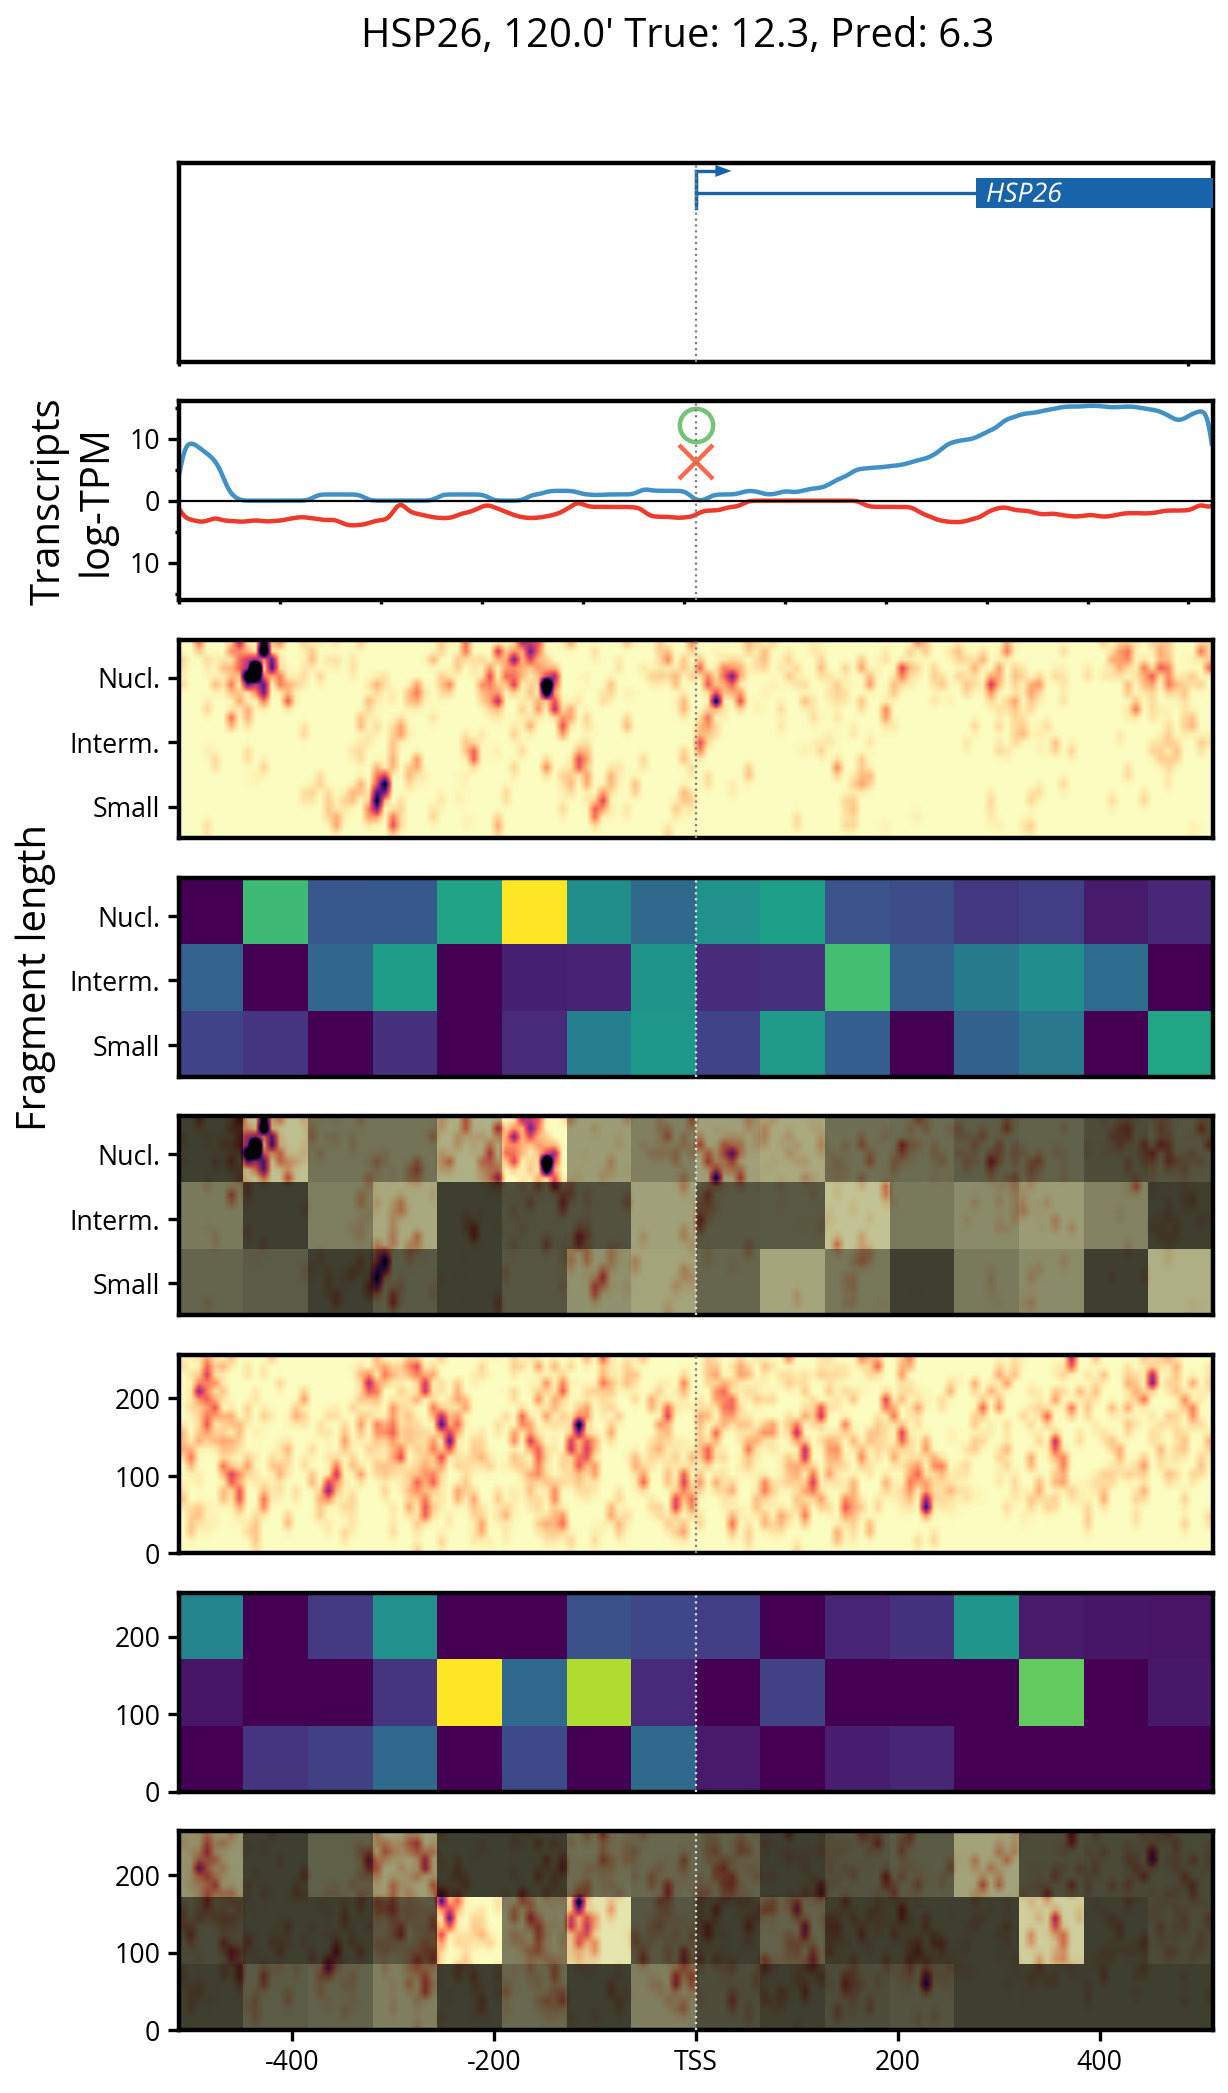

In [181]:
trainer.plot_gene('HSP26', 120)
0

In [78]:
from src.attention_analysis import AttentionAnalysis

a_analysis = AttentionAnalysis(trainer=trainer)

In [89]:
a_analysis.compute_attentions(t=60)

1/4427 - 00:00:00.26
1001/4427 - 00:04:45.40
2001/4427 - 00:09:43.06
3001/4427 - 00:14:19.20
4001/4427 - 00:20:31.12


In [90]:
from src.utils import write_pickle
write_pickle(a_analysis.trainer.collected_attentions,
            f"{trainer.out_dir}/collected_attentions_60.pkl")

Wrote output/cd_24x128_2chan_p1_logfold_20220815_40a7/collected_attentions_60.pkl


In [91]:
import umap

mapper = umap.UMAP().fit(a_analysis.atts_vec_120)

In [98]:
all_indices = np.arange(len(vit_data))

time_t_indices = all_indices[vit_data.times == 60]
tpm_t = vit_data.TPM[time_t_indices]

In [144]:
plt_data = pd.DataFrame(index=a_analysis.orfs_t,
                        data={'x': mapper.embedding_[:, 0], 
                              'y': mapper.embedding_[:, 1],
                              'tpm_lfc': tpm_t})
plt_data = plt_data.sort_values('tpm_lfc')

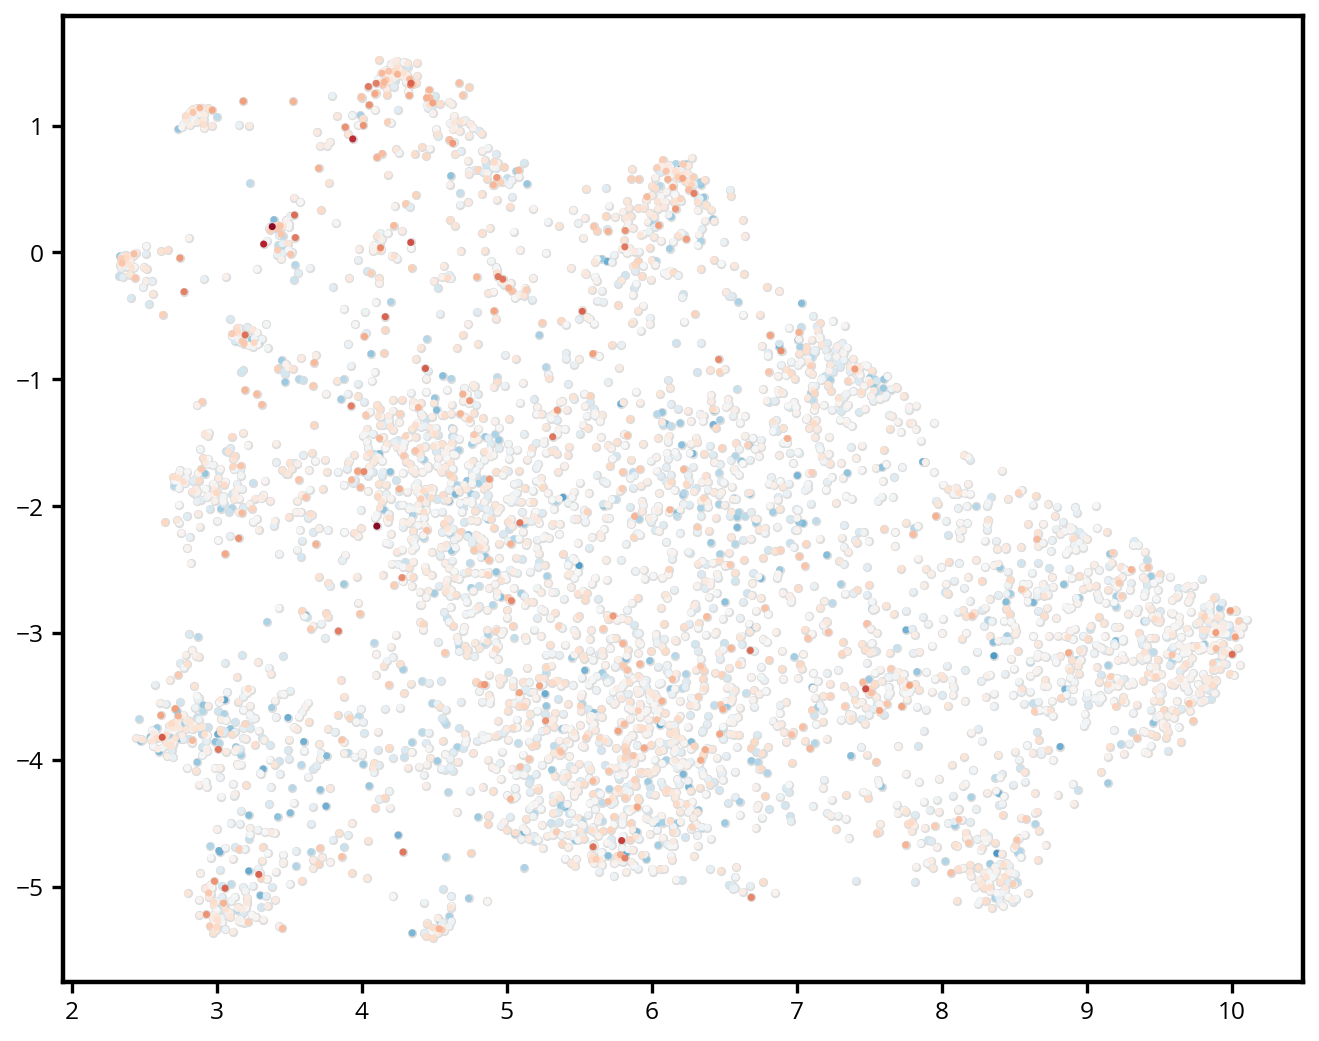

In [177]:
plt.figure(figsize=(10, 8))

plt.scatter(plt_data.x, plt_data.y,
            s=10, c='#dddddd')

plt.scatter(plt_data.x, plt_data.y, c=plt_data.tpm_lfc, edgecolor='none',
           s=10, cmap='RdBu_r', vmin=-8, vmax=8)

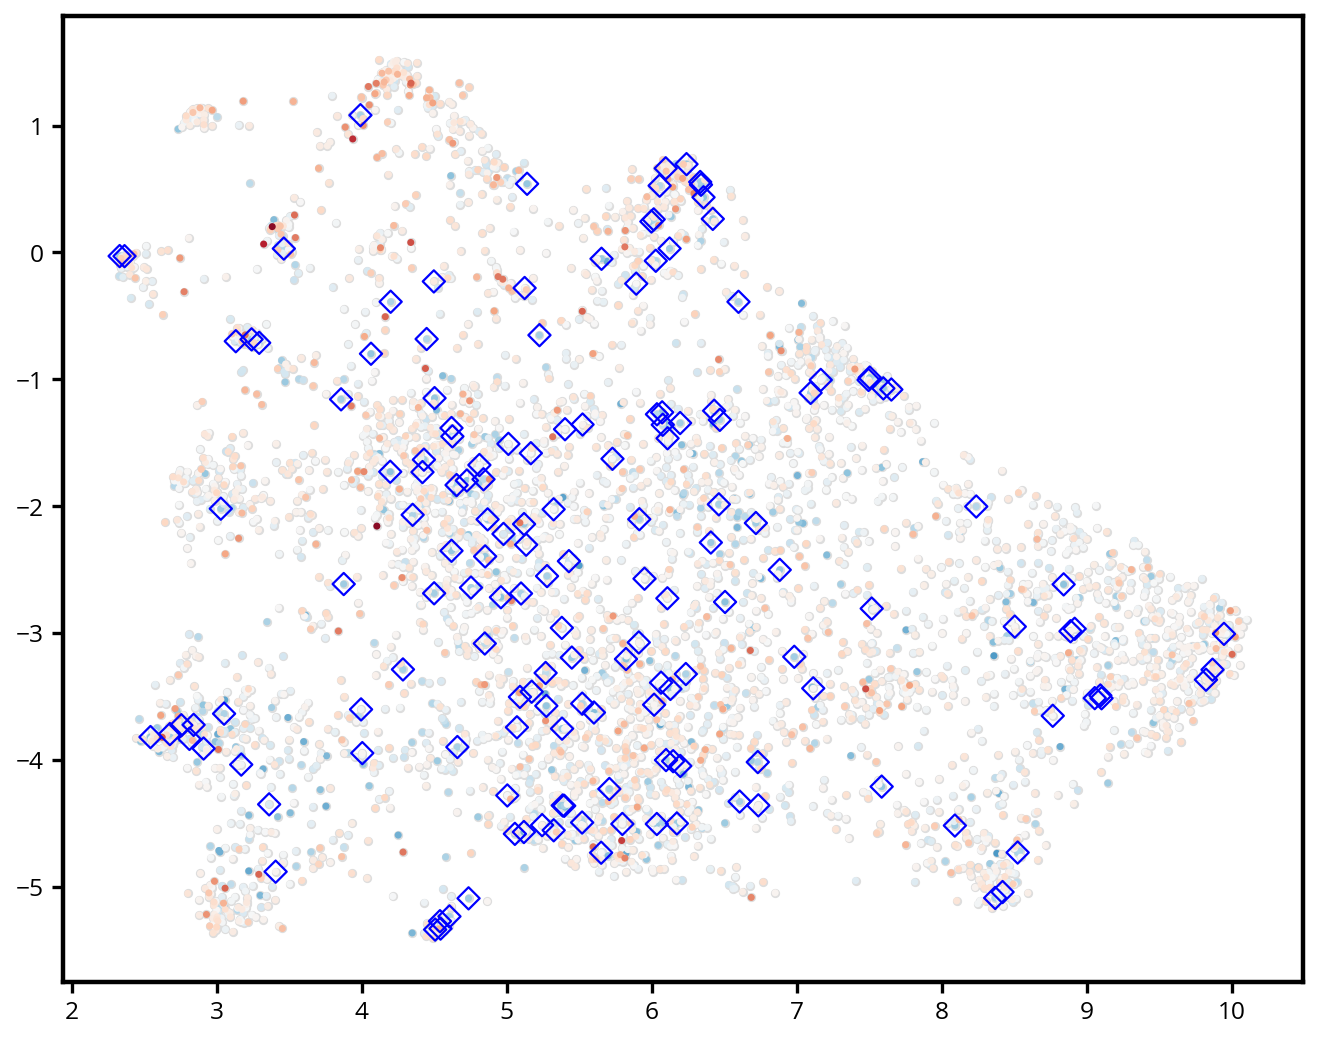

In [175]:
plt.figure(figsize=(10, 8))

plt.scatter(plt_data.x, plt_data.y,
            s=10, c='#dddddd')

plt.scatter(plt_data.x, plt_data.y, c=plt_data.tpm_lfc, edgecolor='none',
           s=10, cmap='RdBu_r', vmin=-8, vmax=8)

selected_data = plt_data.loc[ribosomal_orfs]

plt.scatter(selected_data.x, selected_data.y, edgecolor='blue', marker='D', facecolor='none',
            s=50)


0

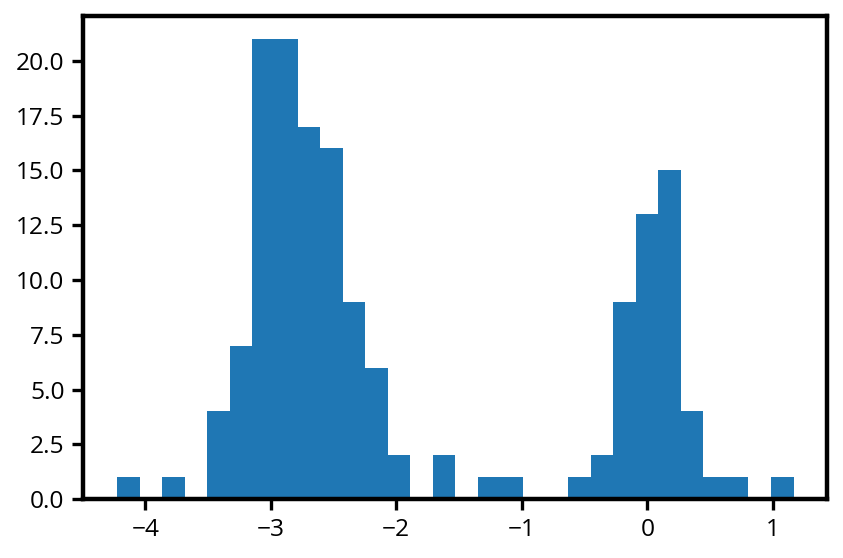

In [176]:
plt.hist(plt_data.tpm_lfc.loc[ribosomal_orfs], bins=30)
0

0

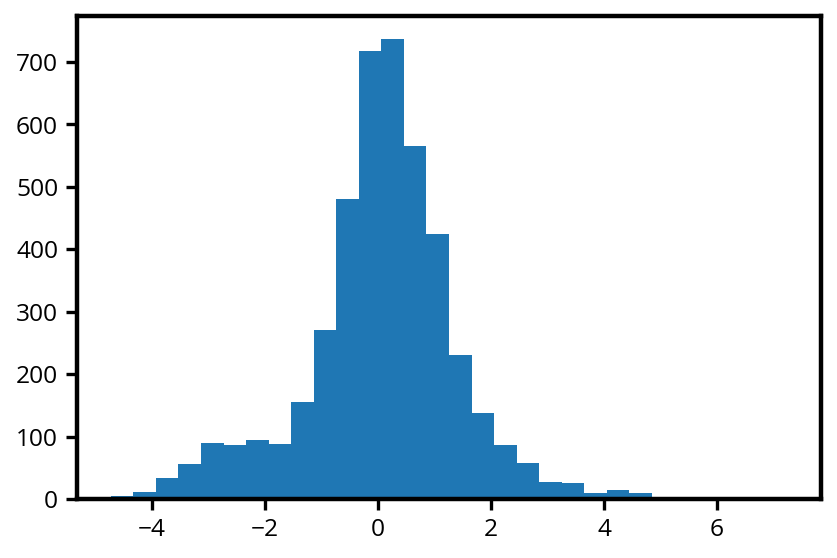

In [122]:
plt.hist(plt_data.tpm_lfc, bins=30)
0

In [143]:
high_orfs = plt_data[plt_data.tpm_lfc > 4].index.values
low_orfs = plt_data[plt_data.tpm_lfc < -4].index.values

In [172]:
from src.reference_data import read_sgd_orfs

def orfs_for_go(go_id):
    orfs_data = read_sgd_orfs()
    orfs = orfs_data[[go_id in o for o in orfs_data.ontology.str.split(',')]].index.values
    return orfs

protein_folding_orfs = orfs_for_go('GO:0051082')
ribosomal_orfs = orfs_for_go('GO:0003735')

In [174]:
lfc_tpm_data = vit_data.read_logfold_tpm_data()
ribosomal_orfs = list(set(lfc_tpm_data.index.values).intersection(ribosomal_orfs))

lfc_tpm_data.loc[ribosomal_orfs].join(vit_data.orfs_data[['name']])

,0.0,7.5,15.0,30.0,60.0,120.0,name
orf_name,,,,,,,
YDR447C,0.0,-0.045629,-0.865671,-2.602966,-4.641678,-5.061161,RPS17B
YDR450W,0.0,-0.068231,-0.901389,-2.335897,-3.936165,-4.292535,RPS18A
YNL137C,0.0,-0.096722,0.313982,0.480539,0.081098,-0.424016,NAM9
YDR405W,0.0,-0.093703,0.226555,0.240967,0.186029,0.033299,MRP20
YGL129C,0.0,0.080989,0.442278,0.492636,0.261748,-0.129673,RSM23
...,...,...,...,...,...,...,...
YOL120C,0.0,-0.128850,-1.124478,-2.701238,-4.559872,-5.272327,RPL18A
YJL136C,0.0,-0.156815,-0.932064,-2.244504,-3.798512,-4.484059,RPS21B
YJR101W,0.0,-0.024021,0.240812,-0.244322,-0.727285,-1.074446,RSM26


In [188]:
vit_data.orfs_data.loc[['YBR072W']]

,name,chr,start,stop,length,strand,orf_class,ontology,TSS,PAS,half_life,coverage
orf_name,,,,,,,,,,,,
YBR072W,HSP26,2,382030,382674,645,+,Verified,"GO:0003729,GO:0005634,GO:0005737,GO:0006457,GO...",381753,382841.0,137.195,0.999


In [207]:
def plot_img(img):
    plt.imshow(img, cmap='magma_r', origin='lower')
    plt.show()

In [296]:
vit_data_2 = load_cd_data_24x128_p1('merge', 0, 'logfold')

In [214]:
indices = np.arange(len(vit_data_2))

sel_indices = indices[vit_data.orfs == 'YBR072W']
sel_times = vit_data_2.times[sel_indices]

sel_imgs = vit_data_2.all_imgs[sel_indices]

(5, 2, 24, 128)

In [304]:
original_imgs = vit_data_2.original_imgs

indices = np.arange(len(original_imgs))

sel_indices = indices[vit_data.original_orfs == 'YBR072W']

sel_imgs = original_imgs[sel_indices]
sel_imgs.shape

(6, 1, 24, 128)

In [306]:
sel_imgs[0, 0].shape

(24, 128)

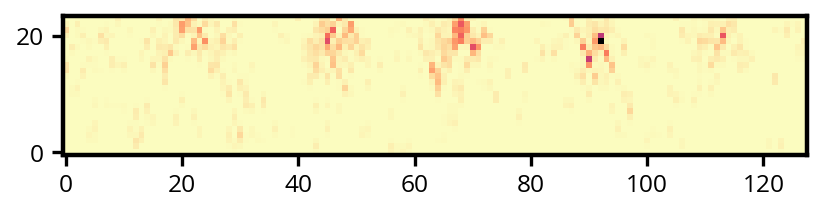

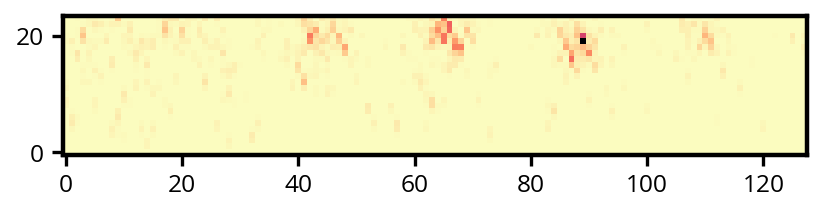

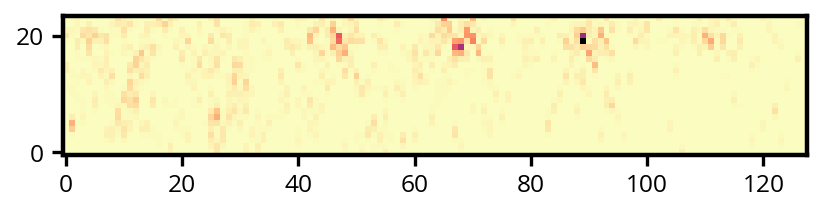

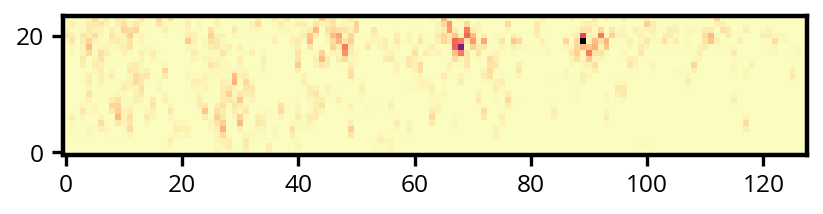

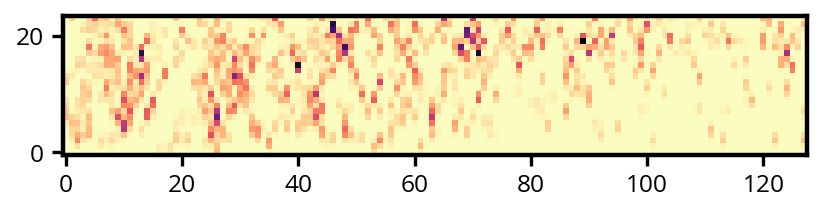

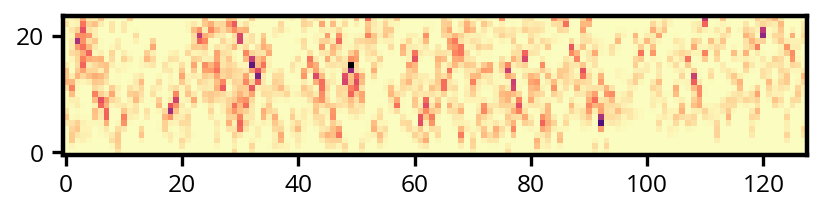

In [305]:
plot_img(sel_imgs[0, 0])
plot_img(sel_imgs[1, 0])
plot_img(sel_imgs[2, 0])
plot_img(sel_imgs[3, 0])
plot_img(sel_imgs[4, 0])
plot_img(sel_imgs[5, 0])
